In [11]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [12]:

# Load the dataset
datapath = "/Users/whysocurious/Documents/MLDSAIProjects/cust-seg-case-study/data"
df = pd.read_csv(datapath+'/Customer Segmentation DeDup.csv')
# df.drop('Unnamed: 0', inplace=True)

# Display basic info about missing values
print("Missing values before imputation:")
print(df.isnull().sum())
print("\n")

# Create a copy for imputation
df_impute = df.copy()

Missing values before imputation:
Customer ID          0
Gender               0
Ever_Married       144
Age                  0
Graduated           80
Profession         128
Work_Experience    857
Spending_Score       0
Family_Size        344
dtype: int64




In [13]:
df_impute.head()

,Customer ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,458982,Male,Yes,61,Yes,Executive,1.0,High,3.0
1,458983,Female,Yes,63,Yes,Executive,0.0,High,5.0
2,458984,Male,Yes,39,Yes,Artist,0.0,Average,3.0
3,458985,Male,No,23,No,Healthcare,1.0,Low,4.0
4,458986,Male,No,18,No,Healthcare,7.0,Low,4.0


In [14]:
# Step 1: Handle categorical variables for KNN
# KNN requires numerical inputs, so we need to encode categorical variables

# Initialize label encoders
le_gender = LabelEncoder()
le_married = LabelEncoder()
le_graduated = LabelEncoder()
le_profession = LabelEncoder()
le_spending = LabelEncoder()

# Encode categorical variables (only for non-missing values initially)
df_impute['Gender_encoded'] = le_gender.fit_transform(df_impute['Gender'])
df_impute['Spending_Score_encoded'] = le_spending.fit_transform(df_impute['Spending_Score'])

# Handle categorical variables with missing values
# Fill missing categorical values temporarily with mode before encoding
df_impute['Ever_Married'].fillna(df_impute['Ever_Married'].mode()[0], inplace=True)
df_impute['Graduated'].fillna(df_impute['Graduated'].mode()[0], inplace=True)
# df_impute['Profession'].fillna(df_impute['Profession'].mode()[0], inplace=True)

# Now encode the filled categorical variables
df_impute['Ever_Married_encoded'] = le_married.fit_transform(df_impute['Ever_Married'])
df_impute['Graduated_encoded'] = le_graduated.fit_transform(df_impute['Graduated'])
df_impute['Profession_encoded'] = le_profession.fit_transform(df_impute['Profession'])


In [15]:
df_impute.head()

,Customer ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Gender_encoded,Spending_Score_encoded,Ever_Married_encoded,Graduated_encoded,Profession_encoded
0,458982,Male,Yes,61,Yes,Executive,1.0,High,3.0,1,1,1,1,4
1,458983,Female,Yes,63,Yes,Executive,0.0,High,5.0,0,1,1,1,4
2,458984,Male,Yes,39,Yes,Artist,0.0,Average,3.0,1,0,1,1,0
3,458985,Male,No,23,No,Healthcare,1.0,Low,4.0,1,2,0,0,5
4,458986,Male,No,18,No,Healthcare,7.0,Low,4.0,1,2,0,0,5


In [16]:
df_impute.isnull().sum()

Customer ID                 0
Gender                      0
Ever_Married                0
Age                         0
Graduated                   0
Profession                128
Work_Experience           857
Spending_Score              0
Family_Size               344
Gender_encoded              0
Spending_Score_encoded      0
Ever_Married_encoded        0
Graduated_encoded           0
Profession_encoded          0
dtype: int64

In [17]:

# Step 2: Select features for KNN imputation
# Choose relevant features that might predict Work_Experience
features_for_imputation = [
    'Age', 
    'Gender_encoded', 
    'Spending_Score_encoded', 
    'Profession_encoded',
    'Work_Experience',
]

# Create subset with selected features
imputation_data = df_impute[features_for_imputation].copy()
imputation_data

,Age,Gender_encoded,Spending_Score_encoded,Profession_encoded,Work_Experience
0,61,1,1,4,1.0
1,63,0,1,4,0.0
2,39,1,0,0,0.0
3,23,1,2,5,1.0
4,18,1,2,5,7.0
...,...,...,...,...,...
8358,43,0,0,0,0.0
8359,31,0,2,0,1.0
8360,22,1,2,0,1.0
8361,66,0,0,2,0.0


In [18]:

# Step 3: Scale the features (important for KNN)
scaler = StandardScaler()
imputation_data_scaled = pd.DataFrame(
    scaler.fit_transform(imputation_data),
    columns=imputation_data.columns,
    index=imputation_data.index
)
imputation_data_scaled.head()

,Age,Gender_encoded,Spending_Score_encoded,Profession_encoded,Work_Experience
0,1.019819,0.909055,-0.425323,0.421002,-0.483423
1,1.138671,-1.100043,-0.425323,0.421002,-0.777378
2,-0.287551,0.909055,-1.604300,-1.096437,-0.777378
3,-1.238365,0.909055,0.753655,0.800361,-0.483423
4,-1.535495,0.909055,0.753655,0.800361,1.280304


In [19]:
imputation_data_scaled.isnull().sum()

Age                         0
Gender_encoded              0
Spending_Score_encoded      0
Profession_encoded          0
Work_Experience           857
dtype: int64

In [20]:

# Step 4: Apply KNN Imputer
# n_neighbors=5 means it will use 5 nearest neighbors to impute missing values
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')

# Perform the imputation
imputed_data_scaled = knn_imputer.fit_transform(imputation_data_scaled)
imputed_data_scaled

array([[ 1.01981908,  0.90905517, -0.42532283,  0.42100154, -0.48342329],
       [ 1.13867089, -1.10004324, -0.42532283,  0.42100154, -0.77737785],
       [-0.28755091,  0.90905517, -1.60430022, -1.09643661, -0.77737785],
       ...,
       [-1.29779135,  0.90905517,  0.75365457, -1.09643661, -0.48342329],
       [ 1.31694862, -1.10004324, -1.60430022, -0.33771754, -0.77737785],
       [-0.04984727, -1.10004324,  0.75365457, -1.09643661, -0.48342329]],
      shape=(8363, 5))

In [21]:

# Step 5: Transform back to original scale
imputed_data = pd.DataFrame(
    scaler.inverse_transform(imputed_data_scaled),
    columns=imputation_data.columns,
    index=imputation_data.index
)
print(imputed_data.isnull().sum())
imputed_data.head()

Age                       0
Gender_encoded            0
Spending_Score_encoded    0
Profession_encoded        0
Work_Experience           0
dtype: int64


,Age,Gender_encoded,Spending_Score_encoded,Profession_encoded,Work_Experience
0,61.0,1.0,1.0,4.000000e+00,1.0
1,63.0,0.0,1.0,4.000000e+00,0.0
2,39.0,1.0,0.0,-4.440892e-16,0.0
3,23.0,1.0,2.0,5.000000e+00,1.0
4,18.0,1.0,2.0,5.000000e+00,7.0


<Axes: >

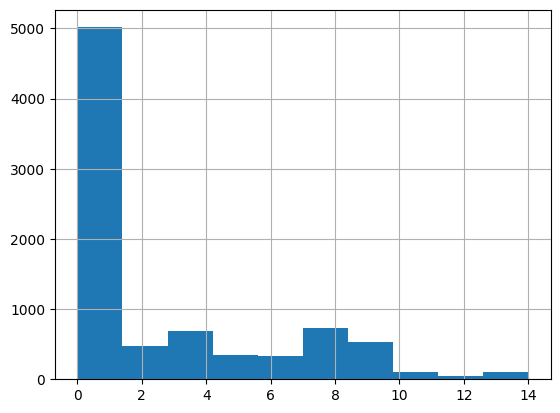

In [22]:
imputed_data['Work_Experience'].hist()

<Axes: >

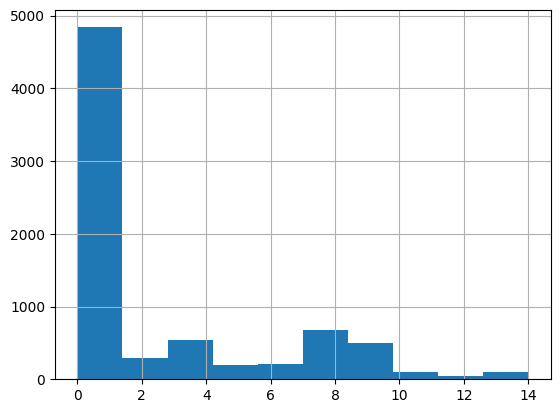

In [23]:
df['Work_Experience'].hist()

In [24]:

# Step 6: Update the original dataframe with imputed Work_Experience
df_final = df.copy()
df_final['Work_Experience'] = imputed_data['Work_Experience']
# df_final['Family_Size'] = imputed_data['Family_Size']  # Also impute Family_Size

# Round Work_Experience to reasonable precision
df_final['Work_Experience'] = df_final['Work_Experience'].round(1)
# df_final['Family_Size'] = df_final['Family_Size'].round(0)

# Ensure non-negative values for Work_Experience
df_final['Work_Experience'] = df_final['Work_Experience'].clip(lower=0)


In [25]:

# Step 7: Validation and Results
print("Missing values after imputation:")
print(df_final.isnull().sum())
print("\n")

print("Work_Experience statistics before and after imputation:")
print("Before imputation:")
print(df['Work_Experience'].describe())
print("\nAfter imputation:")
print(df_final['Work_Experience'].describe())


Missing values after imputation:
Customer ID          0
Gender               0
Ever_Married       144
Age                  0
Graduated           80
Profession         128
Work_Experience      0
Spending_Score       0
Family_Size        344
dtype: int64


Work_Experience statistics before and after imputation:
Before imputation:
count    7506.000000
mean        2.644551
std         3.402113
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        14.000000
Name: Work_Experience, dtype: float64

After imputation:
count    8363.000000
mean        2.746646
std         3.327394
min         0.000000
25%         0.000000
50%         1.000000
75%         5.000000
max        14.000000
Name: Work_Experience, dtype: float64


In [26]:

# Show some examples of imputed values
missing_mask = df['Work_Experience'].isnull()
if missing_mask.sum() > 0:
    print(f"\nSample of imputed Work_Experience values:")
    sample_imputed = df_final.loc[missing_mask, ['Age', 'Gender', 'Profession', 'Work_Experience']].head(10)
    print(sample_imputed)



Sample of imputed Work_Experience values:
    Age  Gender  Profession  Work_Experience
19   20  Female   Marketing              2.6
28   48  Female      Artist              5.4
35   50    Male   Executive              1.8
46   70    Male   Executive              1.0
51   21  Female  Healthcare              7.4
61   57    Male   Executive              0.6
66   66    Male      Artist              0.4
71   63    Male   Executive              0.6
72   69    Male      Lawyer              1.0
74   87    Male   Executive              0.2


In [27]:

# Optional: Save the imputed dataset
# df_final.to_csv('Customer_Segmentation_Imputed.csv', index=False)
print("\nImputation completed successfully!")

# Additional validation: Check for any remaining issues
print(f"\nValidation checks:")
print(f"Any negative work experience values: {(df_final['Work_Experience'] < 0).sum()}")
print(f"Work experience range: {df_final['Work_Experience'].min():.1f} to {df_final['Work_Experience'].max():.1f}")
print(f"Any remaining missing values: {df_final.isnull().sum().sum()}")


Imputation completed successfully!

Validation checks:
Any negative work experience values: 0
Work experience range: 0.0 to 14.0
Any remaining missing values: 696


In [28]:
df_final.isnull().sum()

Customer ID          0
Gender               0
Ever_Married       144
Age                  0
Graduated           80
Profession         128
Work_Experience      0
Spending_Score       0
Family_Size        344
dtype: int64

In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [30]:
def load_and_preprocess_data(file_path):
    """Load customer data and handle initial preprocessing"""
    df = pd.read_csv(file_path)
    print(f"Dataset shape: {df.shape}")
    print(f"Missing values per column:\n{df.isnull().sum()}")
    return df

def encode_categorical_features(df):
    """Convert categorical variables to numeric for KNN imputation"""
    df_encoded = df.copy()
    
    # Store original categorical columns for later decoding
    cat_columns = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'Work_Experience', 'Family_Size']
    encoders = {}
    
    for col in cat_columns:
        if col in df_encoded.columns:
            le = LabelEncoder()
            # Handle missing values by creating a mask
            mask = ~df_encoded[col].isna()
            if mask.sum() > 0:  # Only encode if there are non-null values
                df_encoded.loc[mask, col] = le.fit_transform(df_encoded.loc[mask, col])
                encoders[col] = le
    
    return df_encoded, encoders

In [31]:
def apply_knn_imputation(df_encoded, n_neighbors=5):
    """Apply KNN imputation only to missing values in the encoded dataset"""
    # Separate ID column (don't impute customer IDs)
    id_col = df_encoded[['Customer ID']].copy()
    features_df = df_encoded.drop('Customer ID', axis=1)
    
    # Store original data to preserve non-missing values
    original_features = features_df.copy()
    
    # Create mask for missing values
    missing_mask = features_df.isna()
    
    # Scale features before KNN (important for distance calculations)
    features_scaled = features_df.copy()
    scalers = {}
    
    # Scale each column individually, fitting only on non-missing values
    for col in features_scaled.columns:
        non_missing_mask = ~features_scaled[col].isna()
        if non_missing_mask.sum() > 0:
            scaler = StandardScaler()
            # Fit scaler only on non-missing values
            scaler.fit(features_scaled.loc[non_missing_mask, col].values.reshape(-1, 1))
            # Transform all values (missing will remain NaN)
            features_scaled[col] = scaler.transform(features_scaled[col].values.reshape(-1, 1)).flatten()
            scalers[col] = scaler
    
    # Apply KNN imputation
    imputer = KNNImputer(n_neighbors=n_neighbors, weights='distance')
    features_imputed_scaled = imputer.fit_transform(features_scaled)
    
    # Inverse transform to original scale
    features_imputed = pd.DataFrame(features_imputed_scaled, columns=features_df.columns)
    for col in features_imputed.columns:
        if col in scalers:
            features_imputed[col] = scalers[col].inverse_transform(
                features_imputed[col].values.reshape(-1, 1)
            ).flatten()
    
    # CRITICAL: Only replace missing values, keep original non-missing values
    df_final_features = original_features.copy()
    for col in features_df.columns:
        # Only update values that were originally missing
        missing_indices = missing_mask[col]
        df_final_features.loc[missing_indices, col] = features_imputed.loc[missing_indices, col]
    
    # Add back customer ID
    df_imputed = pd.concat([id_col.reset_index(drop=True), df_final_features], axis=1)
    
    return df_imputed, imputer, scalers

In [32]:
def decode_categorical_features(df_imputed, encoders):
    """Convert encoded categorical variables back to original labels"""
    df_final = df_imputed.copy()
    
    for col, encoder in encoders.items():
        if col in df_final.columns:
            # print (col, df_final[col].unique())
            # Round to nearest integer (KNN might produce decimals)
            df_final[col] = np.round(df_final[col].astype(int)).astype(int)
            
            # Ensure values are within valid range
            max_class = len(encoder.classes_) - 1
            df_final[col] = np.clip(df_final[col], 0, max_class)
            
            # Decode back to original labels
            df_final[col] = encoder.inverse_transform(df_final[col])
    
    return df_final

def validate_imputation_quality(original_df, imputed_df):
    """Check the quality of imputation by comparing distributions"""
    print("\nImputation Quality Check:")
    print("=" * 40)
    
    # Check if any missing values remain
    remaining_missing = imputed_df.isnull().sum().sum()
    print(f"Remaining missing values: {remaining_missing}")
    
    # Verify that non-missing values weren't changed
    print("\nVerifying original values were preserved:")
    columns_with_missing = ['Ever_Married', 'Graduated', 'Profession', 'Work_Experience', 'Family_Size']
    
    for col in columns_with_missing:
        if col in original_df.columns:
            # Get non-missing indices from original data
            non_missing_mask = ~original_df[col].isna()
            
            # Compare original and imputed values for non-missing entries
            if non_missing_mask.sum() > 0:
                original_values = original_df.loc[non_missing_mask, col]
                imputed_values = imputed_df.loc[non_missing_mask, col]
                
                # Check if values are identical (allowing for small floating point differences)
                # if col in ['Work_Experience', 'Family_Size']:
                #     values_preserved = np.allclose(original_values, imputed_values, atol=1e-10)
                # else:
                values_preserved = original_values.equals(imputed_values)
                
                print(f"  {col}: {'✓ Preserved' if values_preserved else '✗ Modified'}")
    
    # Count how many values were actually imputed
    print(f"\nValues imputed per column:")
    for col in columns_with_missing:
        if col in original_df.columns:
            original_missing = original_df[col].isna().sum()
            print(f"  {col}: {original_missing} values imputed")
    
    # Compare distributions before and after imputation (only for reference)
    continuous_cols = ['Age', ]
    
    print(f"\nDistribution comparison (including imputed values):")
    for col in continuous_cols:
        if col in original_df.columns:
            orig_mean = original_df[col].mean()
            imp_mean = imputed_df[col].mean()
            orig_std = original_df[col].std()
            imp_std = imputed_df[col].std()
            
            print(f"\n{col}:")
            print(f"  Original: mean={orig_mean:.2f}, std={orig_std:.2f}")
            print(f"  With imputed: mean={imp_mean:.2f}, std={imp_std:.2f}")
    
    # Check categorical distributions
    categorical_cols = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score','Work_Experience', 'Family_Size']
    
    for col in categorical_cols:
        if col in original_df.columns and original_df[col].isna().sum() > 0:
            print(f"\n{col} distribution comparison:")
            orig_counts = original_df[col].value_counts(normalize=True, dropna=True)
            imp_counts = imputed_df[col].value_counts(normalize=True)
            
            for category in orig_counts.index:
                orig_pct = orig_counts[category] * 100
                imp_pct = imp_counts.get(category, 0) * 100
                print(f"  {category}: {orig_pct:.1f}% -> {imp_pct:.1f}%")


In [33]:
def main():
    # Load the data
    datapath = "/Users/whysocurious/Documents/MLDSAIProjects/cust-seg-case-study/data"
    file_path = datapath+'/Customer Segmentation DeDup.csv'  # Update with your file path
    df = load_and_preprocess_data(file_path)
    
    # Store original data for comparison
    original_df = df.copy()
    
    # Encode categorical variables
    df_encoded, encoders = encode_categorical_features(df)
    
    # Apply KNN imputation with k=5 neighbors (only to missing values)
    df_imputed, imputer, scalers = apply_knn_imputation(df_encoded, n_neighbors=5)
    
    # Decode categorical variables back to original format
    df_final = decode_categorical_features(df_imputed, encoders)
    
    # Ensure integer types for appropriate columns
    df_final['Customer ID'] = df_final['Customer ID'].astype(int)
    df_final['Age'] = np.round(df_final['Age']).astype(int)
    
    # Handle Work_Experience and Family_Size carefully to preserve original values
    # Only round imputed values, keep original non-missing values as they were
    # for col in ['Work_Experience', 'Family_Size']:
    #     missing_mask = original_df[col].isna()
    #     non_missing_mask = ~missing_mask
        
    #     # Keep original values for non-missing entries
    #     df_final.loc[non_missing_mask, col] = original_df.loc[non_missing_mask, col]
        
    #     # Round only the imputed values
    #     if missing_mask.sum() > 0:
    #         if col == 'Work_Experience':
    #             df_final.loc[missing_mask, col] = np.round(df_final.loc[missing_mask, col]).astype(int)
    #         else:  # Family_Size
    #             df_final.loc[missing_mask, col] = np.round(df_final.loc[missing_mask, col]).astype(int)
    
    # Validate imputation quality and verify original values preserved
    validate_imputation_quality(original_df, df_final)
    
    # Save the imputed dataset
    output_file = datapath+'/customer_data_imputed.csv'
    df_final.to_csv(output_file, index=False)
    print(f"\nImputed dataset saved as: {output_file}")
    
    # Print summary of what was imputed
    print(f"\nSummary:")
    print(f"- Total rows processed: {len(df_final)}")
    columns_with_missing = ['Ever_Married', 'Graduated', 'Profession', 'Work_Experience', 'Family_Size']
    total_imputed = 0
    for col in columns_with_missing:
        missing_count = original_df[col].isna().sum()
        total_imputed += missing_count
        print(f"- {col}: {missing_count} missing values imputed")
    print(f"- Total values imputed: {total_imputed}")
    print(f"- Original non-missing values: preserved unchanged")
    
    return df_final


In [34]:

# Alternative function for experimenting with different k values
def experiment_with_k_values(df, k_values=[3, 5, 7, 10]):
    """Test different k values to find optimal number of neighbors"""
    original_df = df.copy()
    df_encoded, encoders = encode_categorical_features(df)
    
    results = {}
    
    for k in k_values:
        print(f"\nTesting k={k}...")
        df_imputed, _, _ = apply_knn_imputation(df_encoded, n_neighbors=k)
        df_final = decode_categorical_features(df_imputed, encoders)
        
        # Preserve original non-missing values
        for col in ['Work_Experience', 'Family_Size']:
            missing_mask = original_df[col].isna()
            non_missing_mask = ~missing_mask
            df_final.loc[non_missing_mask, col] = original_df.loc[non_missing_mask, col]
            if missing_mask.sum() > 0:
                df_final.loc[missing_mask, col] = np.round(df_final.loc[missing_mask, col]).astype(int)
        
        # Calculate quality metrics only on imputed values
        work_exp_missing_mask = original_df['Work_Experience'].isna()
        family_size_missing_mask = original_df['Family_Size'].isna()
        
        work_exp_imputed_values = df_final.loc[work_exp_missing_mask, 'Work_Experience']
        family_size_imputed_values = df_final.loc[family_size_missing_mask, 'Family_Size']
        
        results[k] = {
            'work_exp_imputed_mean': work_exp_imputed_values.mean() if len(work_exp_imputed_values) > 0 else 0,
            'work_exp_imputed_std': work_exp_imputed_values.std() if len(work_exp_imputed_values) > 0 else 0,
            'family_size_imputed_mean': family_size_imputed_values.mean() if len(family_size_imputed_values) > 0 else 0,
            'family_size_imputed_std': family_size_imputed_values.std() if len(family_size_imputed_values) > 0 else 0,
            'work_exp_imputed_count': len(work_exp_imputed_values),
            'family_size_imputed_count': len(family_size_imputed_values)
        }
        
        print(f"  Work_Experience imputed values: mean={results[k]['work_exp_imputed_mean']:.2f}, std={results[k]['work_exp_imputed_std']:.2f}, count={results[k]['work_exp_imputed_count']}")
        print(f"  Family_Size imputed values: mean={results[k]['family_size_imputed_mean']:.2f}, std={results[k]['family_size_imputed_std']:.2f}, count={results[k]['family_size_imputed_count']}")
    
    return results



In [ ]:
if __name__ == "__main__":
    df_imputed = main()
    
    # Uncomment to experiment with different k values
    print("\n" + "="*50)
    print("EXPERIMENTING WITH DIFFERENT K VALUES")
    print("="*50)
    df = load_and_preprocess_data(datapath+'/Customer Segmentation.csv')
    # k_results = experiment_with_k_values(df)

Dataset shape: (8363, 9)
Missing values per column:
Customer ID          0
Gender               0
Ever_Married       144
Age                  0
Graduated           80
Profession         128
Work_Experience    857
Spending_Score       0
Family_Size        344
dtype: int64

Imputation Quality Check:
Remaining missing values: 0

Verifying original values were preserved:
  Ever_Married: ✓ Preserved
  Graduated: ✓ Preserved
  Profession: ✓ Preserved
  Work_Experience: ✓ Preserved
  Family_Size: ✓ Preserved

Values imputed per column:
  Ever_Married: 144 values imputed
  Graduated: 80 values imputed
  Profession: 128 values imputed
  Work_Experience: 857 values imputed
  Family_Size: 344 values imputed

Distribution comparison (including imputed values):

Age:
  Original: mean=43.84, std=16.83
  With imputed: mean=43.84, std=16.83

Ever_Married distribution comparison:
  Yes: 58.5% -> 58.3%
  No: 41.5% -> 41.7%

Graduated distribution comparison:
  Yes: 62.2% -> 61.9%
  No: 37.8% -> 38.1%

P